# ViT for XRD patterns classification  
A 6 classes problem, i.e 6 mineral phases: Calcite, Halite, Quartz, Dolomite, Gibbsite and Hematite  
Identify the mineral phase from an XRD pattern. 

In [1]:
from functools import partial
from netrc import netrc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import datetime
import os
import time

## GPU/CPU

In [2]:
if torch.cuda.is_available():
    print("CUDA is available.")
    print("PyTorch version:", torch.__version__)
    print("CUDA version:", torch.version.cuda)
    print("Number of available GPUs:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is not available.


## Dataloader

In [3]:
classes = ['Halite','Quartz','Dolomite','Calcite','Gibbsite','Hematite']
path = 'Databases/Classification/'
class Diffractogramme(Dataset):
    def __init__(self, train = True):
        """
            train (boolean) : train(True) or test(False) set
        """
        self.train = train
        if self.train:
            self.datalist = pd.read_csv(path+'labels_train_6classes.csv', sep=',',header=None,names=['fichier','train','label']) 
        else :
            self.datalist = pd.read_csv(path+'labels_test_6classes.csv', sep=',',header=None,names=['fichier','train','label'])


    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        file_name = self.datalist['fichier'][idx] #Get file name
        file = pd.read_csv(path+file_name,header=None,skiprows=1,names=['Intensity']) # Read file with pandas
        diffracto = file['Intensity'] # Signal
        label = self.datalist['label'][idx]  #label
        l = classes.index(label)
        diffracto = torch.tensor(diffracto).float() #Convert
        sample = [diffracto,l]
        return sample
    
batch_size = 64
train_data = Diffractogramme(train = True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = Diffractogramme(train = False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## ViT block

In [4]:
class EncoderBlock(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(EncoderBlock, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)
        self.drop_path = DropPath(
            drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class Attention(nn.Module):

    def __init__(self,
                 dim,  
                 num_heads=2,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)

    def forward(self, x):
        # [batch_size, num_patches + 1, total_embed_dim]
        B, N, C = x.shape  
        # qkv(): -> [batch_size, num_patches + 1, 3 * total_embed_dim]
        # reshape: -> [batch_size, num_patches + 1, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # make torchscript happy (cannot use tensor as tuple)
        q, k, v = qkv[0], qkv[1], qkv[2]
        # transpose: -> [batch_size, num_heads, embed_dim_per_head, num_patches + 1]
        # @: multiply -> [batch_size, num_heads, num_patches + 1, num_patches + 1]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        # @: multiply -> [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # transpose: -> [batch_size, num_patches + 1, num_heads, embed_dim_per_head]
        # reshape: -> [batch_size, num_patches + 1, total_embed_dim]
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Mlp(nn.Module):

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    

def Spectra_Embedding(x, spec_length, embed_dim):
    batch_size = x.shape[0]
    new_spec_length = (spec_length // embed_dim) * embed_dim
    x = x[:, :new_spec_length]
    x = torch.reshape(x, (batch_size, spec_length // embed_dim, embed_dim))
    return x

class VIT(nn.Module):
    def __init__(self, spec_length=2000, num_output=1,
                 embed_dim=40, depth=12, num_heads=2, mlp_ratio=4.0, qkv_bias=True,
                 qk_scale=None, drop_ratio=0.,
                 attn_drop_ratio=0., drop_path_ratio=0., norm_layer=None,
                 act_layer=None):
        
        # MSTransformer
        super(VIT, self).__init__()
        self.num_classes = num_output
        self.spec_length = spec_length
        self.num_features = self.embed_dim = embed_dim
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, (spec_length//embed_dim) + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_ratio)
        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]
        self.blocks = nn.Sequential(*[
            EncoderBlock(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                        drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                        norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)
        ])
        self.norm = norm_layer(embed_dim)
        
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(_init_vit_weights)

        self.head = nn.Linear(embed_dim, num_output)

    def forward(self, x):
        # [B , xrd_length] --> [B , xrd_length/embed_dim , embed_dim]
        x = Spectra_Embedding(x, self.spec_length, self.embed_dim)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        x = self.head(x)

        return x[:, 0]
    
def _init_vit_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.zeros_(m.bias)
        nn.init.ones_(m.weight)

def VIT_model(spec_length=2905,num_output: int = 1):
    model = VIT(spec_length=spec_length,
                              embed_dim=80,
                              depth=12,
                              num_heads=2,
                              num_output=num_output)
    return model

## Train the model

In [ ]:
"""
num_classes=6
model = VIT_model(spec_length=2905,num_output=num_classes)
model = model.to(device)
optimizer = Adam(model.parameters())
loss_func = CrossEntropyLoss()

import matplotlib.pyplot as plt

num_epochs = 100
losses = []
early_stop_loss = 0.98 
no_improve_epoch = 0 
patience = 3 
epoch_times = []
total_time=0
for epoch in range(num_epochs):
    start_time = time.time()  
    model.train()
    running_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = loss_func(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    end_time = time.time()  
    epoch_duration = end_time - start_time  
    epoch_times.append(epoch_duration)
    total_time+=epoch_duration
        
        
        

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch: {epoch+1}, Loss: {epoch_loss}, Time: {epoch_duration:.2f}s,Total time:{total_time}')
    
    losses.append(epoch_loss)

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
"""

## Confusion Matrix

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

In [7]:
num_classes=6
model = VIT_model(spec_length=2905,num_output=num_classes)
model.load_state_dict(torch.load('Trained_model/Classif'))
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        #outputs = torch.exp(outputs)/torch.sum(torch.exp(outputs))
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted,labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 600 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 600 test images: 99 %


In [8]:
labels = np.zeros(len(test_data))
prediction = np.zeros(len(test_data))
for i in range(len(test_data)):
    x,l = test_data[i]
    x = torch.unsqueeze(x,0)
    y = model(x)
    prediction[i] = torch.argmax(y, 1)
    labels[i] = l 
cm = confusion_matrix(y_true = labels,y_pred=prediction)

<Figure size 720x1080 with 0 Axes>

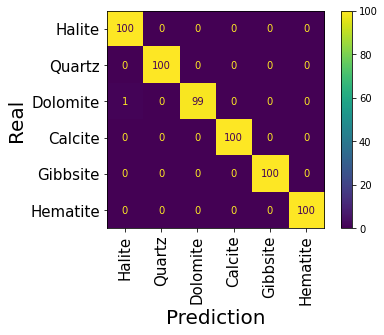

In [9]:
plt.figure(figsize = (10,15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()
disp.ax_.set_xticklabels(classes, fontsize = 15)
disp.ax_.set_yticklabels(classes, fontsize = 15)
plt.xlabel('Prediction', fontsize = 20)
plt.ylabel('Real', fontsize = 20)
plt.xticks(rotation=90)
plt.show()